In [1]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm     # detrending, deseasonality
from statsmodels.tsa.stattools import adfuller    # stationary test 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15,8]

In [11]:
plt.rcParams['figure.figsize'] = [15,8]

In [2]:
# Load the data
train = pd.read_csv('train.csv')

In [3]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
# Pivot the table
train_flattened = pd.melt(train[list(train.columns[10:300])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened.head()

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-10,24.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-10,4.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-10,4.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-10,16.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-10,NaN


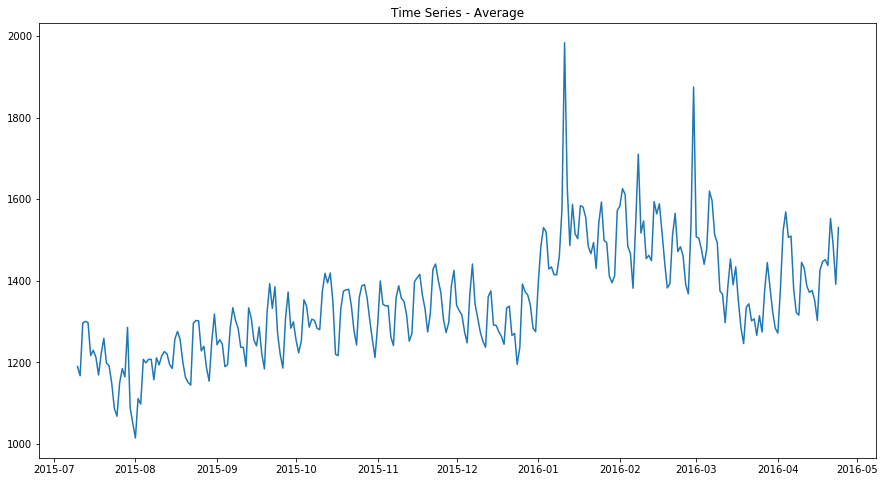

In [12]:
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

### Check Stationarity

In [19]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')   # AIC test 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

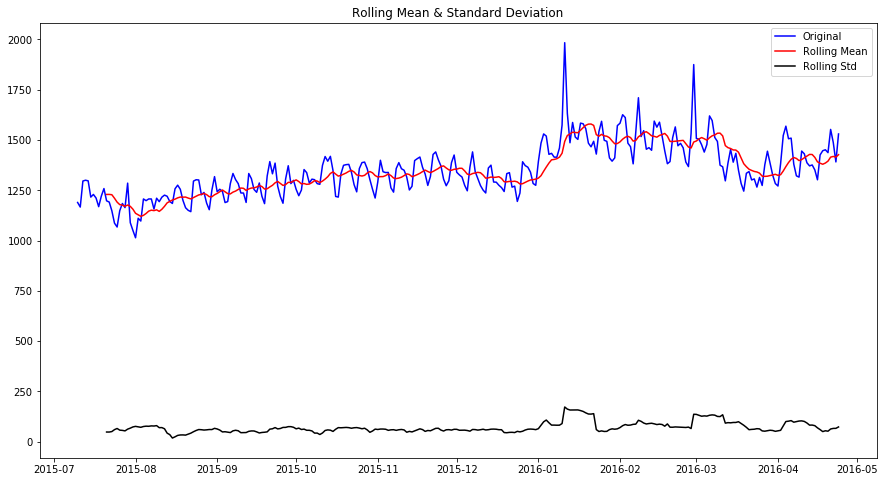

Results of Dickey-Fuller Test:
Test Statistic                  -1.964769
p-value                          0.302231
#Lags Used                      14.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [20]:
test_stationarity(mean_group)

Since the null hypothesis for Dickey Fuller test is non-stationary, p-value of 0.3 implies that the null hypothesis could be accepted (failed to reject the null hypothesis). This process is not stationary.

## Transformation to a stationary process

### Moving Average

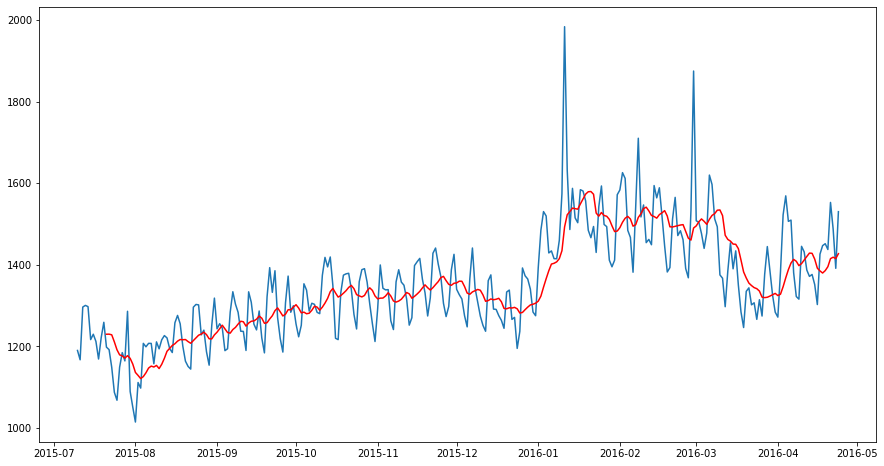

In [21]:
moving_avg = mean_group.rolling(12).mean()
plt.plot(mean_group)
plt.plot(moving_avg, color='red')

In [22]:
moving_avg_diff = mean_group - moving_avg
moving_avg_diff.head(12)

date
2015-07-10         NaN
2015-07-11         NaN
2015-07-12         NaN
2015-07-13         NaN
2015-07-14         NaN
2015-07-15         NaN
2015-07-16         NaN
2015-07-17         NaN
2015-07-18         NaN
2015-07-19         NaN
2015-07-20         NaN
2015-07-21   -31.72006
Name: Visits, dtype: float64

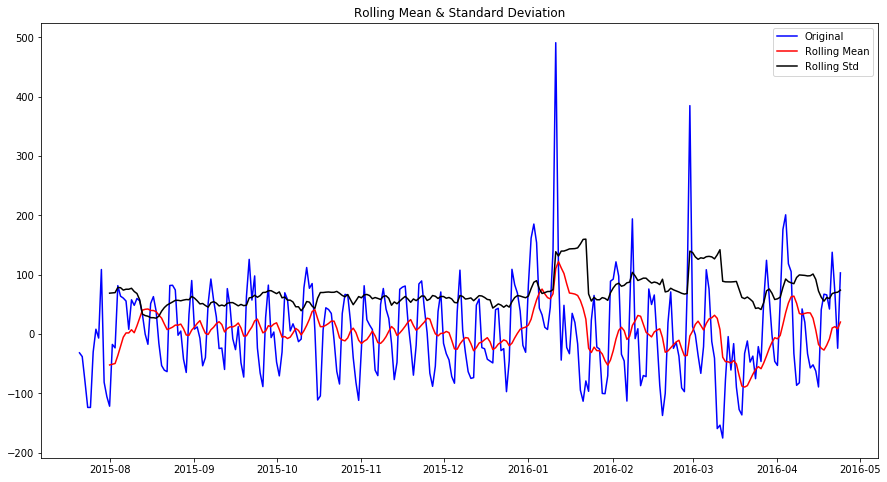

Results of Dickey-Fuller Test:
Test Statistic                  -4.767407
p-value                          0.000063
#Lags Used                      14.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [23]:
moving_avg_diff.dropna(inplace=True)
test_stationarity(moving_avg_diff)

### Exponential Weighted Moving Average

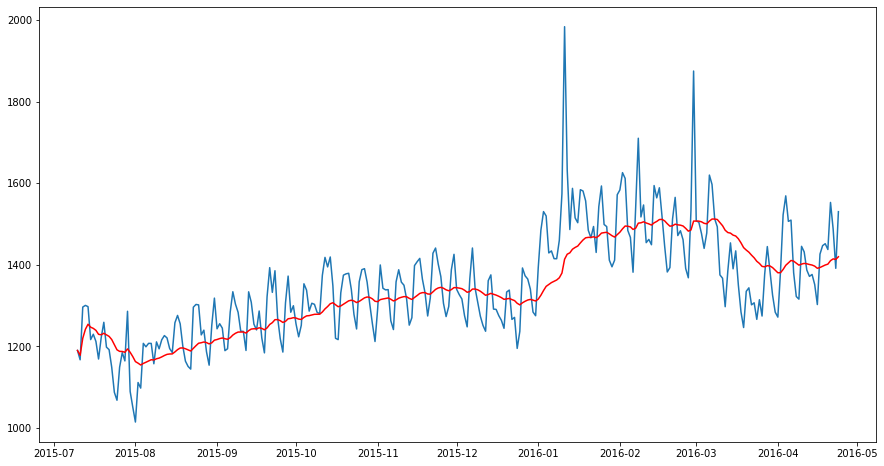

In [24]:
expwighted_avg = mean_group.ewm(halflife=12).mean()
plt.plot(mean_group)
plt.plot(expwighted_avg, color='red')

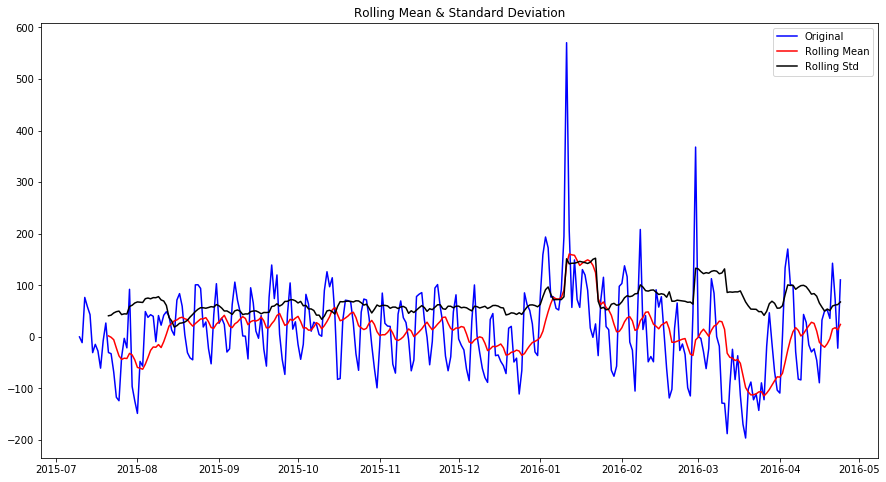

Results of Dickey-Fuller Test:
Test Statistic                  -3.654931
p-value                          0.004794
#Lags Used                      14.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [25]:
ewma_diff = mean_group - expwighted_avg
test_stationarity(ewma_diff)

### Differencing

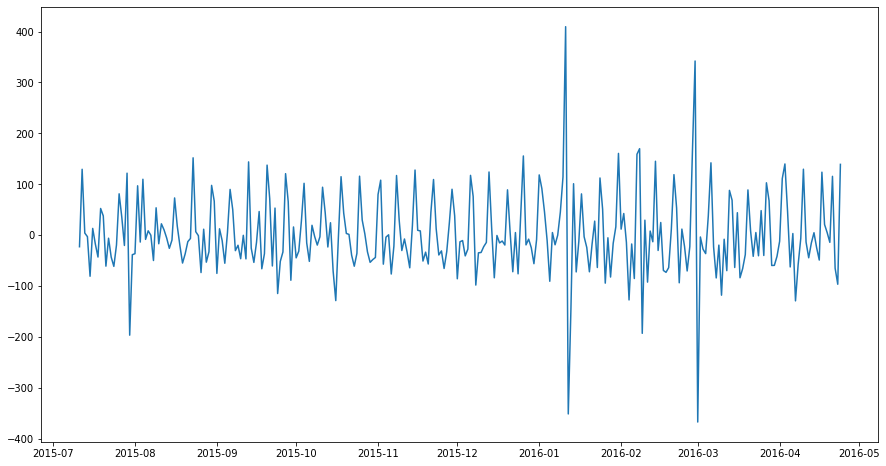

In [26]:
mean_group_diff = mean_group - mean_group.shift()
plt.plot(mean_group_diff)

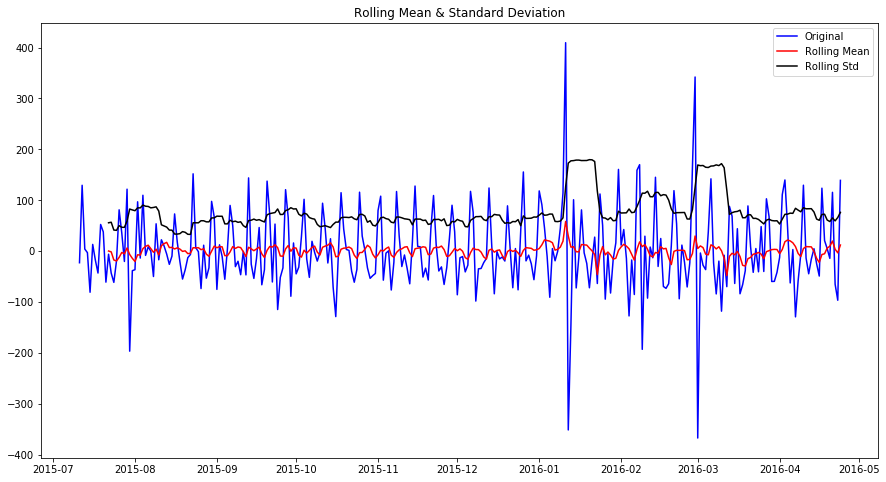

Results of Dickey-Fuller Test:
Test Statistic                  -4.670382
p-value                          0.000096
#Lags Used                      13.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [27]:
mean_group_diff.dropna(inplace=True)
test_stationarity(mean_group_diff)

## Decomposing

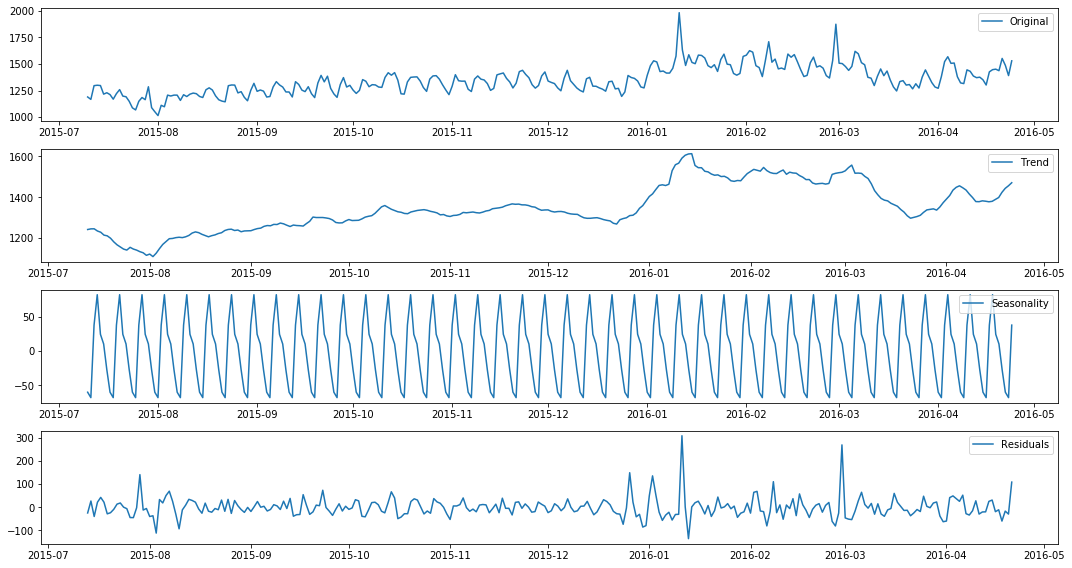

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mean_group)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(mean_group, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

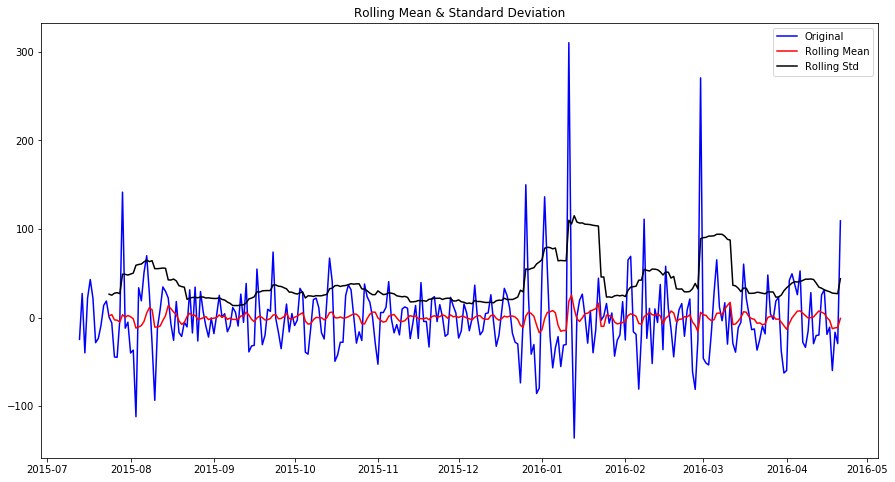

Results of Dickey-Fuller Test:
Test Statistic                -1.111005e+01
p-value                        3.679340e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.760000e+02
Critical Value (1%)           -3.454267e+00
Critical Value (5%)           -2.872070e+00
Critical Value (10%)          -2.572381e+00
dtype: float64


In [29]:
mean_group_decompose = residual
mean_group_decompose.dropna(inplace=True)
test_stationarity(mean_group_decompose)

## Forecasting

### ACF and PACF

In [30]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(residual, nlags=20)
lag_pacf = pacf(residual, nlags=20, method='ols')

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


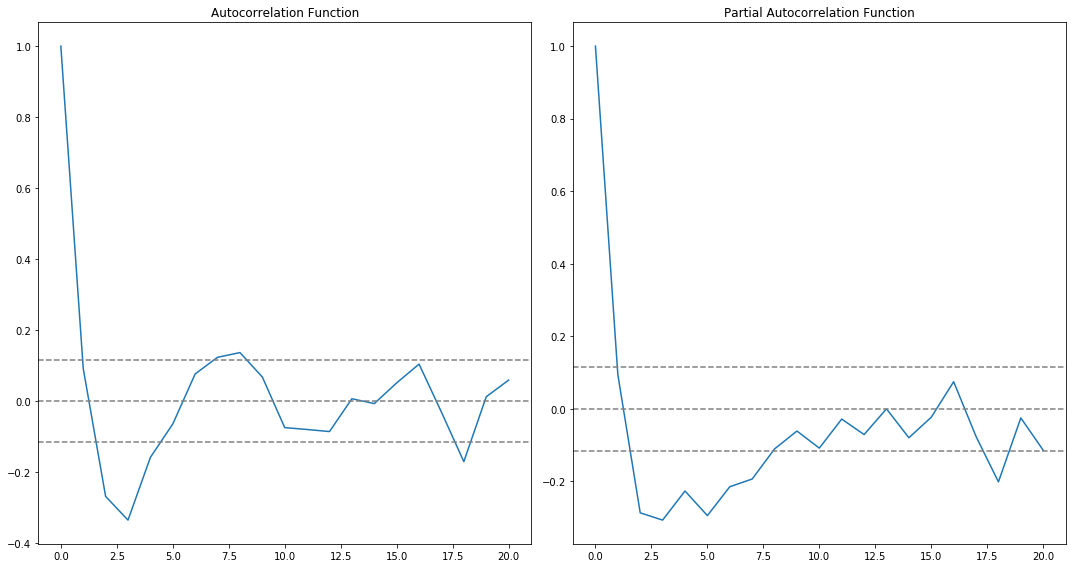

In [31]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### AR model  AR(1)

In [32]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import aicc

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 537412.2141')

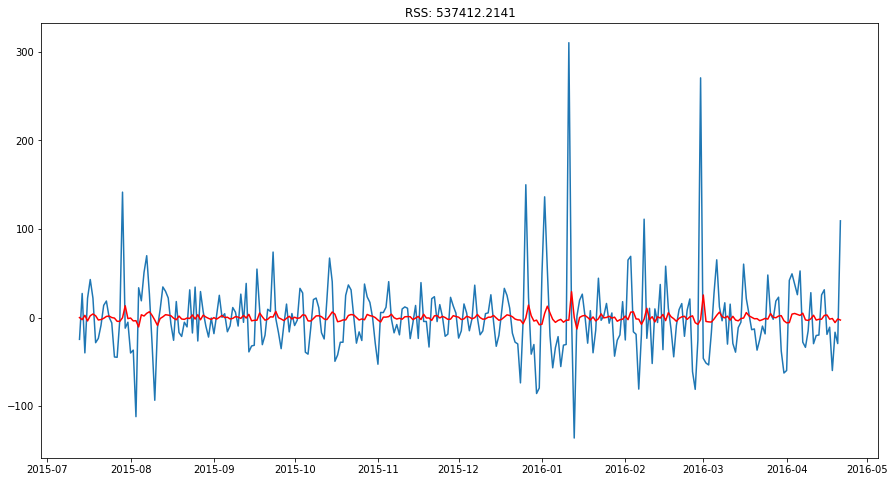

In [33]:
model = ARIMA(residual, order=(1, 0, 0))  # parameters p,d,q
results_AR = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-residual)**2))

### MA(1)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 533371.8530')

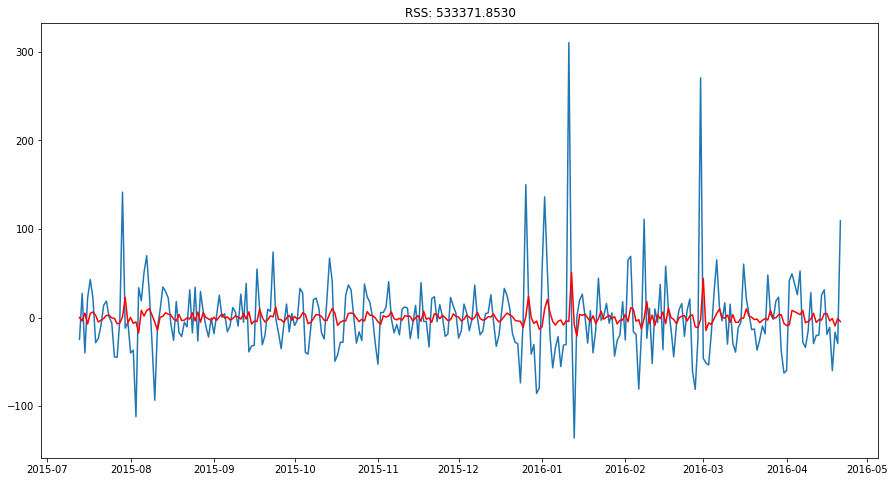

In [34]:
model = ARIMA(residual, order=(0, 0, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-residual)**2))

### ARMA(1,1)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 420239.2137')

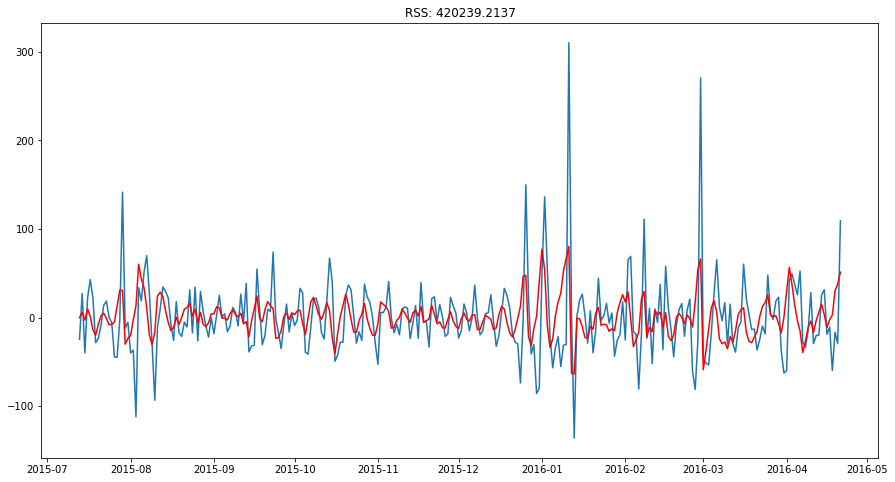

In [36]:
model = ARIMA(residual, order=(1, 0, 1))   # parameters: p = 1, d = 0, q = 1,
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))

### Grid search for p, q

In [39]:
# aic ~= cross validation score, pick the minimum
mat_aic = np.zeros((5,5))
for p in range(1, 6):
    for q in range(1, 6):
        try:
            model = ARIMA(residual, order=(p, 0, q))  
            results_ARIMA = model.fit(disp=-1)  
            mat_aic[p-1][q-1] = results_ARIMA.aic
        except:
            print("not invertible")

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site

not invertible
not invertible
not invertible
not invertible
not invertible


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


not invertible
not invertible
not invertible


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


not invertible


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-

not invertible


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-

In [40]:
mat_aic
# (2,2) is the minimum

array([[2887.99190499,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        , 2827.50598956,    0.        ,    0.        ,
           0.        ],
       [2828.18895184, 2829.48307146, 2831.21974245, 2833.07691743,
           0.        ],
       [2829.63036333, 2831.44436791, 2833.16165032, 2832.69584094,
           0.        ],
       [2830.69162039, 2831.95189936, 2831.54453718, 2830.72063404,
        2832.17625687]])

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2827.505989564655


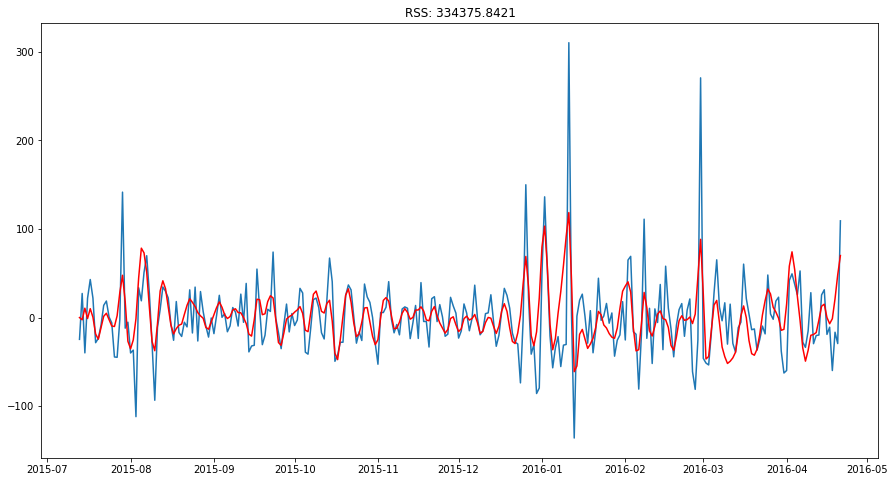

In [42]:
model = ARIMA(residual, order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))
print(results_ARIMA.aic)

## Transfer back to original scale

In [43]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA.head())

date
2015-07-13    -0.003773
2015-07-14    -2.499802
2015-07-15    10.577782
2015-07-16    -1.083782
2015-07-17    10.035728
dtype: float64


In [44]:
predictions_all = pd.Series(0, index=mean_group.index)
predictions_all = predictions_all.add(trend).add(seasonal).add(predictions_ARIMA)
print(predictions_all.head())

date
2015-07-10           NaN
2015-07-11           NaN
2015-07-12           NaN
2015-07-13    1324.83271
2015-07-14    1267.52277
dtype: float64


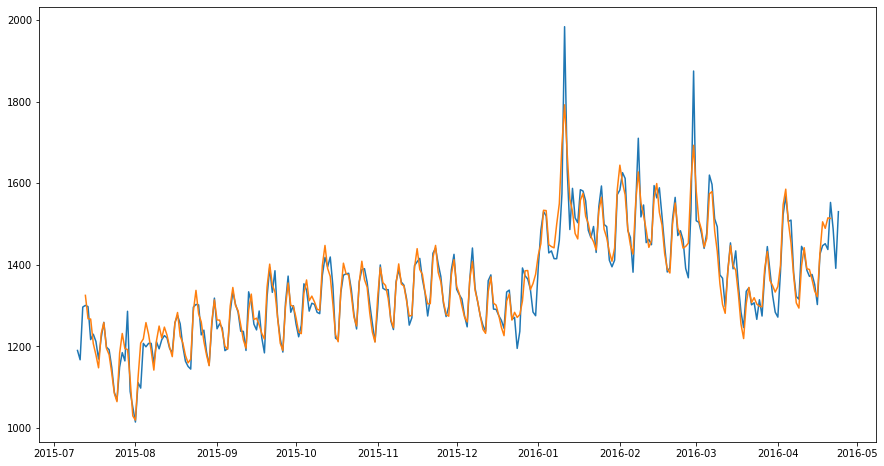

In [45]:
plt.plot(mean_group)
plt.plot(predictions_all)